# Docs

 * https://hsc.gov.ua/wp-content/uploads/2021/02/nomera-proekt-1.pdf
 * https://docs.dtkt.ua/download/pdf/1233.587.1

In [1]:
import os
import sys
import random
import cv2
import json
import string
import tqdm
import numpy as np
from imutils.perspective import four_point_transform
from skimage import exposure

from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import cauchy, logistic

import imutils
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
from _paths import nomeroff_net_dir
from nomeroff_net.tools import modelhub

import albumentations as A
from nomeroff_net.tools.image_processing import get_cv_zone_rgb, distance

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dimabendera/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def visualize(image):
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(image)

In [3]:
plt.rcParams["figure.figsize"] = (20,20)

In [4]:
info = modelhub.download_repo_for_model("yolov5")
repo_path = info["repo_path"]

# auto download latest dataset
info = modelhub.download_dataset_for_model("yolov5")
PATH_TO_DATASET = info["dataset_path"]

In [5]:
ROOT_DIR = PATH_TO_DATASET
dataset = "train"
json_data_path = "train/via_region_data.json"
RES_DIR = os.path.join(PATH_TO_DATASET, "../../../TextDetector/EuUaFrom2004Generated")
os.makedirs(RES_DIR, exist_ok=True)

In [6]:
fontpath = os.path.join(nomeroff_net_dir, 
                                      "data/font/186-font.otf")
images_formats = [
    #"eu-ua-2015-2.png",
    #"eu-ua-2015-3.png",
    "eu-ua-2015.png",
]
path_to_images_example = os.path.join(nomeroff_net_dir, 
                                      "data/dataset/OptionsDetector/numberplate_options_example/train/img/{}")

seria = [
    "AA",	"BA",	"CA",	"EA",	"HA",	"IA",	"KA",	"MA",	"OA",	"PA",	
    "TA",	"XA",	"AB",	"BB",	"CB",	"EB",	"HB",	"IB",	"KB",	"MB",	
    "OB",	"PB",	"TB",	"XB",	"AC",	"BC",	"CC",	"EC",	"HC",	"IC",	
    "KC",	"MC",	"OC",	"PC",	"TC",	"XC",	"AE",	"BE",	"CE",	"EE",	
    "HE",	"IE",	"KE",	"ME",	"OE",	"PE",	"TE",	"XE",	"AH",	"BH",	
    "CH",	"EH",	"HH",	"IH",	"KH",	"MH",	"OH",	"PH",	"TH",	"XH",	
    "AI",	"BI",	"CI",	"EL",	"HI",	"II",	"KI",	"MI",	"OI",	"PI",	
    "TI",	"XI",	"AK",	"BK",	"CK",	"EK",	"HK",	"IK",	"KK",	"MK",	
    "OK",	"PK",	"TK",	"XK",	"AM",	"BM",	"CM",	"EM",	"HM",	"IM",	
    "KM",	"MM",	"OM",	"PM",	"TM",	"XM",	"AO",	"BO",	"CO",	"EO",	
    "HO",	"IO",	"KO",	"MO",	"OO",	"PO",	"TO",	"XO",	"AP",	"BP",	
    "CP",	"EP",	"HP",	"IP",	"KP",	"MP",	"OP",	"PP",	"TP",	"XP",	
    "AT",	"BT",	"CT",	"ET",	"HT",	"IT",	"KT",	"MT",	"OT",	"PT",	
    "TT",	"XT",	"AX",	"BX",	"CX",	"EX",	"HX",	"IX",	"KX",	"MX",	
    "OX",	"PX",	"TX",	"XX",   "YU",	"YV",	"YX",	"YY",	"YZ",
    "XF",	"XG",	"XJ",	"XL",	"XN",	"XR",	"XS",	"XU",	"XV",	
    "XY",	"XZ",	"FF",	"FG",	"FJ",	"FL",	"FN",	"FR",	"FS",	"FU",	
    "FV",	"FY",	"FZ",	"AF",	"AG",	"AJ",	"AL",	"AN",	"AR",	
    "AS",	"AU",	"AV",	"TF",	"TG",	"TJ",	"TL",	"TN",	"TR",	
    "TS",	"TU",	"TV",	"TY",	"TZ",	"ZA",	"ZB",	"ZC",	"ZD",	
    "ZE",	"ZF",	"ZG",	"ZH",	"ZI",	"ZJ",	"ZK",	"ZL",	"ZM",	"ZN",	
    "ZO",	"ZP",	"ZR",	"ZS",	"ZT",	"ZU",	"ZV",	"ZX",	"ZY",	
    "ZZ",	"YA",	"YB",	"YC",	"YD",	"YE",	"YF",	"YG",	"YH",	"YI",	
    "YJ",	"YK",	"YL",	"YM",	"YN",	"YO",	"YP",	"YR",	"YS",	"YT",	
    "XW",	"YW",	"FW",	"AW",	"TW",	"ZW",	
]

In [7]:
avaliable_letters = list(set("".join(seria)))

In [8]:
font = ImageFont.truetype(fontpath, 44)

# READ DATASET

In [9]:
res_datasets = {}
res_datasets[dataset] = []

with open(os.path.join(ROOT_DIR, json_data_path)) as jsonFile:
    json_data = json.load(jsonFile)
for key in tqdm.tqdm((json_data["_via_img_metadata"])):
    metadata = json_data["_via_img_metadata"][key]

    # define image_id
    image_file_name = metadata["filename"]
    image_file_name = os.path.join(ROOT_DIR, dataset, image_file_name)
    for region in metadata["regions"]:
        if region["shape_attributes"].get("all_points_x", None) is None or region["shape_attributes"].get("all_points_y", None) is None:
            continue
        np_zone = [(x, y) for x, y in zip(region["shape_attributes"]["all_points_x"], region["shape_attributes"]["all_points_y"])]
        res_datasets[dataset].append([image_file_name, np_zone])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8411/8411 [00:00<00:00, 344057.61it/s]


# TOOLS FUNCTIONS

In [10]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [11]:
def show_linear_cdf(image, channel, name, ax):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    ax.step(bins, freq, c='b', label='Actual CDF')
    ax.plot(target_bins, target_freq, c='r', label='Target CDF')
    ax.legend()
    ax.set_title('{} Channel: Actual vs. '
                 'Target Cumulative Distribution'.format(name))

def linear_distribution(image, channel):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    new_vals = np.interp(freq, target_freq, target_bins)
    return new_vals[image_intensity].astype(np.uint8)


def individual_channel(image, dist, channel):
    im_channel = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(im_channel)
    new_vals = np.interp(freq, dist.cdf(np.arange(0,256)), 
                               np.arange(0,256))
    return new_vals[im_channel].astype(np.uint8)


def distribution(image, function, mean, std):
    dist = function(mean, std)
    image_intensity = img_as_ubyte(rgb2gray(image))
    freq, bins = cumulative_distribution(image_intensity)
    red = individual_channel(image, dist, 0)
    green = individual_channel(image, dist, 1)
    blue = individual_channel(image, dist, 2)
    corrected_image = np.dstack((red, green, blue))
    return corrected_image

In [12]:
def get_random_img():
    random_i = random.randint(0, len(res_datasets[dataset]))
    fake_img_path, fake_np_four_points = res_datasets[dataset][random_i]

    fake_img = cv2.imread(fake_img_path)[:,:,::-1]
    fake_img = np.concatenate((fake_img, 255*np.ones((*fake_img.shape[:2], 1))), axis=2)
    ordered_p_fake = order_points(np.array(fake_np_four_points, dtype = "float32"))

    return fake_img, ordered_p_fake


def draw_fake(img, fake_img, ordered_p_fake):
    ordered_p_orig = np.array([(0, 0), 
                               (img.shape[1], 0), 
                               (img.shape[1], img.shape[0]), 
                               (0, img.shape[0])], dtype = "float32")
    

    M = cv2.getPerspectiveTransform(ordered_p_orig, 
                                    ordered_p_fake)
    warped = cv2.warpPerspective(img, M, (fake_img.shape[1], fake_img.shape[0]))
    cntrs = ordered_p_fake.reshape(1, ordered_p_fake.shape[0], ordered_p_fake.shape[1]).astype(np.int32)

    stencil = np.zeros(warped.shape).astype(warped.dtype)
    contours = cntrs
    
    cv2.fillPoly(stencil, contours, [255, 255, 255])
    np_mask = cv2.bitwise_and(warped, stencil)
    
    overlay_img1 = np.ones(fake_img.shape, np.uint8)*255
    
    rows, cols, channels = np_mask.shape
    overlay_img1[:, :] = warped
    img2gray = cv2.cvtColor(overlay_img1, cv2.COLOR_BGR2GRAY)
    
    ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
        
    mask_inv = cv2.bitwise_not(mask)

    fake_img = fake_img.astype(np.uint8)
    temp1 = cv2.bitwise_and(fake_img, fake_img, mask = mask_inv)
    temp2 = cv2.bitwise_and(overlay_img1, overlay_img1, mask = mask)
    
    temp1 = temp1.astype(np.uint8)
    fake_np_img = cv2.add(temp1, temp2)
    return fake_np_img

In [13]:
def domain_adoptation(src, trg, freq):

    """
    Parameters: 
    src - source image, which style has to be changed
    trg - target image, which low-frequency domain will be adopted
    freq - number of frequencies to be used

    Returns:
    result - np.array based on srs image (shape and high frequencies) 
         with low frequencies of the target image
    """

    result = np.zeros((src.shape[0],src.shape[1],src.shape[2]))

    for i in range(src.shape[2]):
        trg_fft = np.fft.fft2(trg[:,:,i])
        src_fft = np.fft.fft2(src[:,:,i])

        trg_fft_shift = np.fft.fftshift(trg_fft)
        src_fft_shift = np.fft.fftshift(src_fft)

        src_fft_shift[src.shape[0]//2-freq:src.shape[0]//2+freq,
                         src.shape[1]//2-freq:src.shape[1]//2+freq] = \
            trg_fft_shift[trg.shape[0]//2-freq:trg.shape[0]//2+freq,
                           trg.shape[1]//2-freq:trg.shape[1]//2+freq]

        src_ifft_shift = np.fft.ifftshift(src_fft_shift)

        result[:,:,i] = np.fft.ifft2(src_ifft_shift)
        result[:,:,i] = np.abs(result[:,:,i])

    result = np.float32(result)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    result = cv2.normalize(result,None,0,1,cv2.NORM_MINMAX)

    return result

In [14]:
def color_transfer(source, target):
    source = cv2.resize(source, (target.shape[1], target.shape[0]))
    # convert the images from the RGB to L*ab* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")
    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)
    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar
    # scale by the standard deviations
    l = (lStdTar / lStdSrc) * l
    a = (aStdTar / aStdSrc) * a
    b = (bStdTar / bStdSrc) * b
    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc
    # clip the pixel intensities to [0, 255] if they fall outside
    # this range
    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)
    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)

    # return the color transferred image
    return transfer


def image_stats(image):
    # compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())
    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

In [15]:
def draw_fake_numberplate(img, 
                          x: int = 25, y: int = 5, w: int = 226, h: int = 40, 
                          b: int = 2, g: int = 2, r: int = 2, a: int = 255):
    img = img.copy()
    random_img, ordered_p_fake = get_random_img()
    random_img = random_img.astype(np.uint8)
    
    #print(ordered_p_fake)
    random_img_np = get_cv_zone_rgb(random_img, ordered_p_fake)
#     print("random_img_np", np.mean(random_img_np[:,:,:3]), np.max(random_img_np[:,:,:3]), 
#           np.min(random_img_np[:,:,:3]))
#     plt.imshow(random_img_np)
#     plt.show()
    
    draw = ImageDraw.Draw(img)
    draw.rectangle([(x, y), (w, h)], fill ="white", outline ="white")
    numberpalte = random.choice(seria) + "".join(random.choices(string.digits, k=4)) \
                                       + random.choice(seria)
    
    draw.text((27, 8), numberpalte[:2], font = font, fill = (b, g, r, a))
    draw.text((87, 8), numberpalte[2:6], font = font, fill = (b, g, r, a))
    draw.text((175.5, 8), numberpalte[6:], font = font, fill = (b, g, r, a))
    
    img = np.array(img)
#     print("orig color", np.mean(img[:,:,:3]), np.max(img[:,:,:3]), np.min(img[:,:,:3]))
#     plt.imshow(img)
#     plt.show()
    
    img[:,:,:3] = color_transfer(random_img_np, img[:,:,:3])
    # "speckle", "poisson", "s&p",  "gauss"
    #img[:,:,:3] = noisy("gauss", img[:,:,:3])
    #img[:,:,:3] = domain_adoptation(src=img[:,:,:3], trg=random_img_np, freq=1)
    #img[:,:,:3] = distribution(img[:,:,:3], cauchy,  np.mean(random_img), np.mean(random_img)+90)
    
#     print("color corrected", np.mean(img[:,:,:3]), np.min(img[:,:,:3]), np.max(img[:,:,:3]))
#     plt.imshow(img)
#     plt.show()
    
    fake_img = draw_fake(img, random_img, ordered_p_fake)
    return fake_img, img, numberpalte, ordered_p_fake

In [16]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show=True, **kwargs):

    augmented = aug(image=image)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)
    
    if show:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
        f.tight_layout()

        if filename is not None:
            f.savefig(filename)
        
    return augmented['image']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

In [22]:
def crop_and_aug_numbeplate(np_img, ordered_p_fake):
    l = np.random.uniform(0.01, 0.06)
    np_img = np_img[:,:,:3].astype(np.uint8)
    #print(np_img.shape)
    # img_np = cv2.polylines(np_img, [ordered_p_fake.reshape((-1, 1, 2)).astype(np.int32)], True, (255, 0, 255), 2)
    
    d1 = (distance(ordered_p_fake[0], ordered_p_fake[1])+distance(ordered_p_fake[3], ordered_p_fake[3]))/2*l
    d2 = (distance(ordered_p_fake[1], ordered_p_fake[2])+distance(ordered_p_fake[3], ordered_p_fake[0]))/2*l
    ordered_p_fake[0,0] -= d1
    ordered_p_fake[1,0] += d1
    ordered_p_fake[2,0] += d1
    ordered_p_fake[3,0] -= d1
    
    ordered_p_fake[1,1] -= d2
    ordered_p_fake[2,1] += d2
    ordered_p_fake[0,1] -= d2
    ordered_p_fake[3,1] += d2
    img_np = get_cv_zone_rgb(np_img, ordered_p_fake)
    
    light = A.Compose([
        A.RandomBrightnessContrast(p=1),    
        A.RandomGamma(p=1),    
        A.CLAHE(p=1),
        A.Blur(),
        A.GaussNoise(),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=2, p=.75),
    ], p=5)

    
    # img_np = cv2.polylines(np_img, [ordered_p_fake.reshape((-1, 1, 2)).astype(np.int32)], True, (0, 255, 255), 2)
    return augment_and_show(light, img_np, show=False)

/var/www/nomeroff-net/examples/ju/dataset_tools/../../../data/dataset/OptionsDetector/numberplate_options_example/train/img/eu-ua-2015.png
XP1408YR


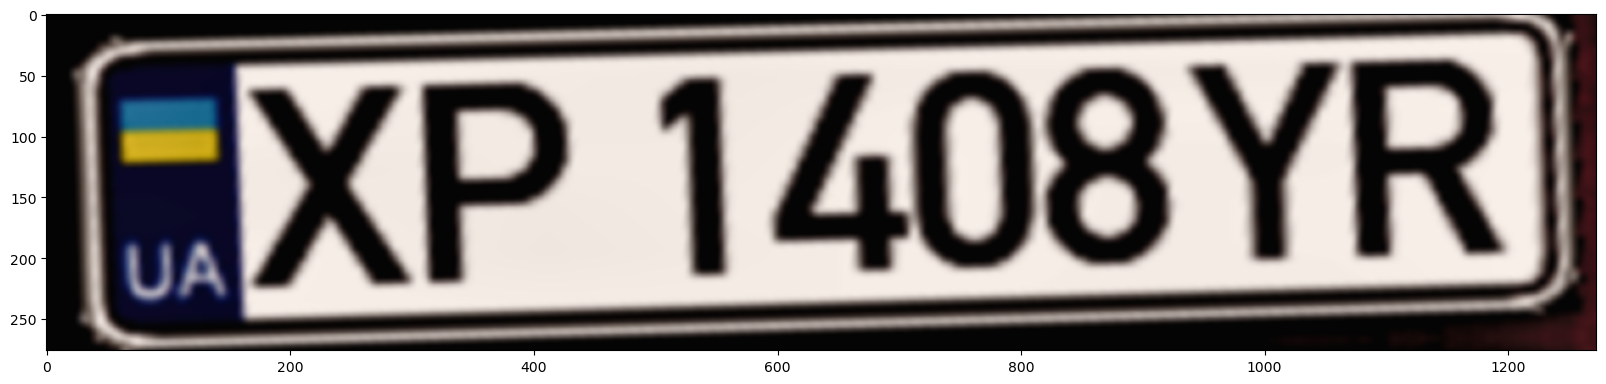

In [43]:
# TEST IM4043WC
for image_format in images_formats:
    print(path_to_images_example.format(image_format))
    img = Image.open(path_to_images_example.format(image_format))
    gen_img, img_crop, numberplate, np_points = draw_fake_numberplate(img)
    print(numberplate)
    np_img = crop_and_aug_numbeplate(gen_img, np_points)
    plt.imshow(np_img)
    plt.show()
#     plt.imshow(gen_img)
#     plt.show()